# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

Nesse anúncio, o host deve descrever as características do imóvel da forma mais completa possível, de forma a ajudar os locadores/viajantes a escolherem o melhor imóvel para eles (e de forma a tornar o seu anúncio mais atrativo)

Existem dezenas de personalizações possíveis no seu anúncio, desde quantidade mínima de diária, preço, quantidade de quartos, até regras de cancelamento, taxa extra para hóspedes extras, exigência de verificação de identidade do locador, etc.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

Elas estão disponíveis para download abaixo da aula (se você puxar os dados direto do Kaggle pode ser que encontre resultados diferentes dos meus, afinal as bases de dados podem ter sido atualizadas).

Caso queira uma outra solução, podemos olhar como referência a solução do usuário Allan Bruno do kaggle no Notebook: https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb

Você vai perceber semelhanças entre a solução que vamos desenvolver aqui e a dele, mas também algumas diferenças significativas no processo de construção do projeto.

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Expectativas Iniciais

- Acredito que a sazonalidade pode ser um fator importante, visto que meses como dezembro costumam ser bem caros no RJ
- A localização do imóvel deve fazer muita diferença no preço, já que no Rio de Janeiro a localização pode mudar completamente as características do lugar (segurança, beleza natural, pontos turísticos)
- Adicionais/Comodidades podem ter um impacto significativo, visto que temos muitos prédios e casas antigos no Rio de Janeiro

Vamos descobrir o quanto esses fatores impactam e se temos outros fatores não tão intuitivos que são extremamente importantes.

### Importar Bibliotecas e Bases de Dados

In [1]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

from sklearn.model_selection import train_test_split

# Importar uma biblioteca para gráfico interativo
import plotly.express as px

In [2]:
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho_bases = pathlib.Path('dataset')

bases = []

for arquivo in caminho_bases.iterdir():
    nome_mes = arquivo.name[:3]
    mes = meses[nome_mes]

    ano = arquivo.name[-8:]
    ano = int(ano.replace('.csv', ''))

    df = pd.read_csv(caminho_bases / arquivo.name)
    df['ano'] = ano
    df['mes'] = mes
    bases.append(df)

base_airbnb = pd.concat(bases)
# display(base_airbnb)

C:\Users\anton\AppData\Local\Temp\ipykernel_6532\3979662229.py:14: DtypeWarning: Columns (62,87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\anton\AppData\Local\Temp\ipykernel_6532\3979662229.py:14: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\anton\AppData\Local\Temp\ipykernel_6532\3979662229.py:14: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\anton\AppData\Local\Temp\ipykernel_6532\3979662229.py:14: DtypeWarning: Columns (87) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(caminho_bases / arquivo.name)
C:\Users\anton\AppData\Local\Temp\ipykernel_6532\3979662229.py:14: DtypeWarning: Columns (61,62,94) have mixed types.

### Consolidar Base de Dados

- Como temos muitas colunas, nosso modelo pode acabar ficando muito lento.

- Além disso, uma análise rápida permite ver que várias colunas não são necessárias para o nosso modelo de previsão, por isso, vamos excluir agumas colunas da nossa base

- Tipos de colunas que vamos excluir:

    1. IDs, Links e informações não relevantes para o modelo
    2. Colunas repetidas ou extremamente parecidas com outra(que dão a mesma informação para o modelo. Ex: Data x Ano/mês)
    3. Colunas preenchidas com texto livre -> Não rodaremos nenhuma análise de palavras ou algo do tipo
    4. Colunas em que todos ou quase todos os valores são iguais

- Para isso, vamos criar um arquivo em excel com os 1.000 primeiros registros e fazer uma análise qualitativa

In [3]:
print(list(base_airbnb.columns))
base_airbnb.head(1000).to_csv('primeiros_registros.csv', sep=';')

['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary', 'space', 'description', 'experiences_offered', 'neighborhood_overview', 'notes', 'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'host_has_profile_pic', 'host_identity_verified', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet', 'price', 'weekly_price', 'monthly_price', '

### Se tivermos muitas colunas, já vamos identificar quais colunas podemos excluir

In [4]:
print(base_airbnb[['host_acceptance_rate']].value_counts())

host_acceptance_rate
100%                    31697
0%                       4744
50%                      3781
99%                      3320
67%                      3140
                        ...  
16%                        22
15%                        21
7%                         20
51%                        18
6%                         11
Name: count, Length: 100, dtype: int64


In [5]:
print((base_airbnb['host_listings_count'] == base_airbnb['host_total_listings_count']).value_counts())
# Colunas diferentes

True     901750
False       460
Name: count, dtype: int64


In [6]:
print(base_airbnb['square_feet'].isnull().sum())

888162


In [7]:
base_airbnb_analise = pd.read_csv('primeiros_registros_tratado.csv')
display(base_airbnb_analise)

host_response_time host_response_rate  host_listings_count  \
0                  NaN                NaN                  1.0   
1       within an hour               100%                  2.0   
2       within an hour               100%                  1.0   
3       within an hour               100%                  3.0   
4       within an hour               100%                  1.0   
..                 ...                ...                  ...   
995                NaN                NaN                  1.0   
996                NaN                NaN                  1.0   
997       within a day               100%                  2.0   
998                NaN                NaN                  1.0   
999       within a day               100%                  2.0   

    host_is_superhost                 latitude                longitude  \
0                   f  -22.946.854.109.114.200  -43.182.737.237.144.500   
1                   t   -2.296.591.903.141.140   -4.317.896.230.586.560   
2                   f     -229.856.978.888.963   -4.320.193.477.968.930   
3                   f  -22.977.116.804.101.800   -4.319.045.414.722.080   
4                   t   -2.298.302.369.705.460   -4.321.427.004.586.680   
..                ...                      ...                      ...   
995                 f  -22.959.723.387.479.500   -4.321.414.280.256.630   
996                 f   -2.292.295.883.478.910   -4.322.929.831.925.910   
997                 f  -22.933.884.094.915.000   -4.318.318.713.300.390   
998                 f  -22.965.481.876.094.000   -4.323.189.810.746.180   
999                 f   -2.292.264.953.645.040   -4.318.586.374.921.610   

    property_type        room_type  accommodates  bathrooms  ...  \
0       Apartment  Entire home/apt             4        1.0  ...   
1     Condominium  Entire home/apt             5        1.0  ...   
2       Apartment  Entire home/apt             2        1.0  ...   
3       Apartment  Entire home/apt             3        1.0  ...   
4       Apartment  Entire home/apt             3        1.0  ...   
..            ...              ...           ...        ...  ...   
995     Apartment  Entire home/apt             6        3.0  ...   
996     Apartment     Private room             4        1.0  ...   
997     Apartment     Private room             1        3.0  ...   
998         House     Private room             1        1.0  ...   
999     Apartment     Private room             2        1.0  ...   

     review_scores_cleanliness  review_scores_checkin  \
0                          9.0                    9.0   
1                          9.0                   10.0   
2                         10.0                   10.0   
3                         10.0                   10.0   
4                         10.0                   10.0   
..                         ...                    ...   
995                       10.0                   10.0   
996                        NaN                    NaN   
997                       10.0                   10.0   
998                        NaN                    NaN   
999                        9.0                   10.0   

    review_scores_communication review_scores_location review_scores_value  \
0                           9.0                    9.0                 9.0   
1                          10.0                    9.0                 9.0   
2                          10.0                   10.0                 9.0   
3                          10.0                   10.0                 9.0   
4                          10.0                   10.0                 9.0   
..                          ...                    ...                 ...   
995                         6.0                    8.0                 4.0   
996                         NaN                    NaN                 NaN   
997                        10.0                    9.0                 9.0   
998                         

### Depois da análise qualitativa das colunas, levando em conta os critérios explicados acima, ficamos com as seguintes colunas:

In [8]:
# Lendo o arquivo tratado ja com as 34 colunas escolhidas
arquivo = pd.read_csv(r'primeiros_registros_tratado.csv', sep=',')

# Pegar o nome das colunas do arquivo e transformando em lista
nomes_colunas = list(arquivo.columns)

# Exibindo a lista com o nome das colunas
print(nomes_colunas)

['host_response_time', 'host_response_rate', 'host_listings_count', 'host_is_superhost', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'ano', 'mes']


In [9]:
# Editando o dataframe "base_airbnb" para usar o DF tratado
base_airbnb = base_airbnb.loc[:, nomes_colunas]
display(base_airbnb)

host_response_time host_response_rate  host_listings_count  \
0                     NaN                NaN                  1.0   
1          within an hour               100%                  2.0   
2          within an hour               100%                  1.0   
3          within an hour               100%                  3.0   
4          within an hour               100%                  1.0   
...                   ...                ...                  ...   
34324      within an hour                93%                  0.0   
34325                 NaN                NaN                  0.0   
34326  within a few hours                74%                 32.0   
34327                 NaN                NaN                  0.0   
34328  a few days or more                38%                  5.0   

      host_is_superhost   latitude  longitude property_type        room_type  \
0                     f -22.946854 -43.182737     Apartment  Entire home/apt   
1                     t -22.965919 -43.178962   Condominium  Entire home/apt   
2                     f -22.985698 -43.201935     Apartment  Entire home/apt   
3                     f -22.977117 -43.190454     Apartment  Entire home/apt   
4                     t -22.983024 -43.214270     Apartment  Entire home/apt   
...                 ...        ...        ...           ...              ...   
34324                 f -23.003180 -43.342840     Apartment  Entire home/apt   
34325                 f -22.966640 -43.393450     Apartment  Entire home/apt   
34326                 f -22.962080 -43.175520     Apartment  Entire home/apt   
34327                 f -23.003400 -43.341820     Apartment  Entire home/apt   
34328                 f -23.010560 -43.363350     Apartment     Private room   

       accommodates  bathrooms  ...  review_scores_cleanliness  \
0                 4        1.0  ...                        9.0   
1                 5        1.0  ...                        9.0   
2                 2        1.0  ...                       10.0   
3                 3        1.0  ...                       10.0   
4                 3        1.0  ...                       10.0   
...             ...        ...  ...                        ...   
34324             4        1.0  ...                        NaN   
34325             4        2.0  ...                        NaN   
34326             5        1.0  ...                        NaN   
34327             4        1.0  ...                        NaN   
34328             2        0.0  ...                        NaN   

       review_scores_checkin review_scores_communication  \
0                        9.0                         9.0   
1                       10.0                        10.0   
2                       10.0                        10.0   
3                       10.0                        10.0   
4                       10.0                        10.0   
...                      ...                         ...   
34324                    NaN                         NaN   
34325                    NaN                         NaN   
34326                    NaN                         NaN   
34327                    NaN                         NaN   
34328                    NaN                         NaN   

      review_scores_location review_scores_value instant_bookable  \
0                        9.0                 9.0                f   
1                        9.0                 9.0                t   
2                       10.0                 9.0                f   
3                       10.0                 9.0                f   
4                       10.0                 9.0                t   
...                      ...                 ...              ...   
34324                    NaN                 NaN                f   
34325                    NaN                 NaN                f   
34326                    NaN                 NaN                f   
34327        

### Tratar Valores Faltando

- Visualizando os dados, percebemos que existe uma grande disparidade em dados faltantes. As colunas com mais de 300.000 valores NaN foram excluídas da análise;
- Para as outras colunas, como temos muitos dados(mais de 900.000 linhas) vamos excluir as linhas que contém dados NaN;

In [10]:
print(base_airbnb.isnull().sum())
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)

print(base_airbnb.isnull().sum())

host_response_time             401843
host_response_rate             401846
host_listings_count               460
host_is_superhost                 460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
maximum_nights                      0
minimum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
review_score

In [11]:
print(base_airbnb.shape)

base_airbnb = base_airbnb.dropna().copy()
print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(902210, 23)
(897709, 23)
host_listings_count         0
host_is_superhost           0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
maximum_nights              0
minimum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
ano                         0
mes                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [12]:
print(base_airbnb.dtypes)
print('-'*60)
print(base_airbnb.iloc[0])

host_listings_count         float64
host_is_superhost            object
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
maximum_nights                int64
minimum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_listings_count                                                       1.0
host_is_superhost  

- Como preço e extra_people estão sendo reconhecidas como objeto (ao invés de ser um float) temos que mudar o tipo de variável da coluna

In [13]:
# Mudanças de tipos

# Price
base_airbnb['price'] = base_airbnb['price'].astype(str)
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '', regex=False)
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '', regex=False)
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)

# extra_people
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(str)
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

# Verificando os tipos
print(base_airbnb.dtypes)
print('-'*60)
print(base_airbnb.iloc[0])


host_listings_count         float64
host_is_superhost            object
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
maximum_nights                int64
minimum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
ano                           int64
mes                           int64
dtype: object
------------------------------------------------------------
host_listings_count                                                       1.0
host_is_superhost  

### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir
    
- Vamos começar pelas colunas de preço (resultado final que queremos) e de extra_people (também valor monetário). Esses são os valores numéricos contínuos.

- Depois vamos analisar as colunas de valores numéricos discretos (accomodates, bedrooms, guests_included, etc.)

- Por fim, vamos avaliar as colunas de texto e definir quais categorias fazem sentido mantermos ou não.

MAS CUIDADO: não saia excluindo direto outliers, pense exatamente no que você está fazendo. Se não tem um motivo claro para remover o outlier, talvez não seja necessário e pode ser prejudicial para a generalização. Então tem que ter uma balança ai. Claro que você sempre pode testar e ver qual dá o melhor resultado, mas fazer isso para todas as features vai dar muito trabalho.

Ex de análise: Se o objetivo é ajudar a precificar um imóvel que você está querendo disponibilizar, excluir outliers em host_listings_count pode fazer sentido. Agora, se você é uma empresa com uma série de propriedades e quer comparar com outras empresas do tipo também e se posicionar dessa forma, talvez excluir quem tem acima de 6 propriedades tire isso do seu modelo. Pense sempre no seu objetivo

                     host_listings_count  latitude  longitude  accommodates  \
host_listings_count             1.000000 -0.034115   0.063635      0.069320   
latitude                       -0.034115  1.000000   0.370416     -0.142082   
longitude                       0.063635  0.370416   1.000000     -0.121746   
accommodates                    0.069320 -0.142082  -0.121746      1.000000   
bathrooms                       0.022332 -0.169135  -0.170504      0.521909   
bedrooms                        0.039712 -0.165050  -0.186332      0.675913   
beds                            0.042788 -0.113931  -0.110392      0.692740   
price                           0.092306 -0.092437  -0.085526      0.269929   
guests_included                 0.041932 -0.091123   0.049375      0.317563   
extra_people                   -0.031589 -0.041113   0.001723      0.078709   
maximum_nights                 -0.000100 -0.001386   0.003403     -0.004242   
minimum_nights                 -0.006441 -0.016090  

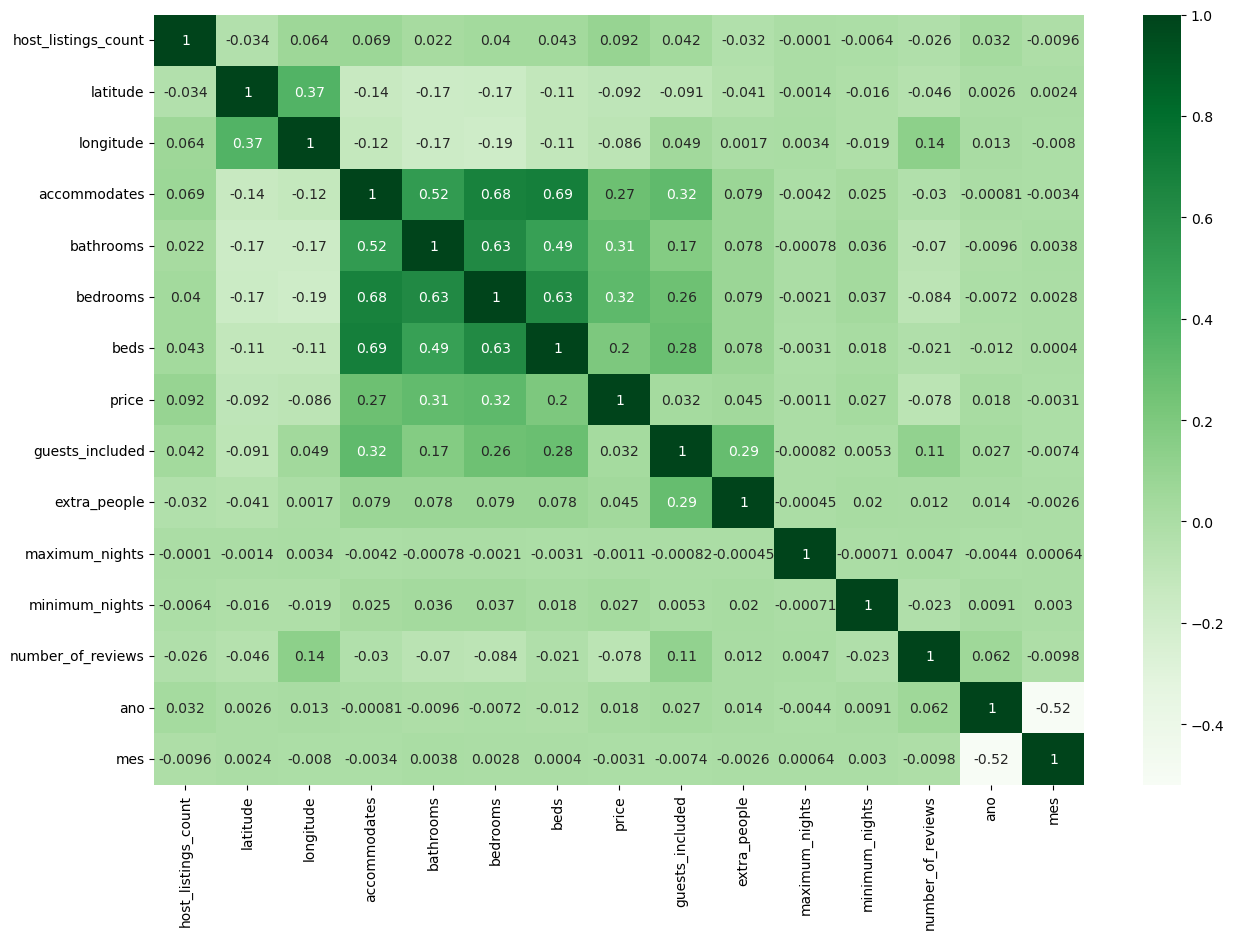

In [14]:
plt.figure(figsize=(15, 10))
sns.heatmap(base_airbnb.corr(numeric_only=True), annot=True, cmap='Greens')
print(base_airbnb.corr(numeric_only=True))

### Definição de Funções para Análise de Outliers

Vamos definir algumas funções para ajudar na análise de outliers das colunas

In [15]:
def limites(coluna):
    q1 = coluna.quantile(0.25)
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude # Limite inferior, limite_superior

def excluir_outliers(df, nome_coluna):
    qtde_linhas = df.shape[0]
    lim_inferior, lim_superior = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inferior) & (df[nome_coluna] <= lim_superior), :]
    linhas_removidas = qtde_linhas - df.shape[0]
    return df, linhas_removidas

def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5)
    sns.boxplot(x=coluna, ax=ax1)
    ax2.set_xlim(limites(coluna))
    sns.boxplot(x=coluna, ax=ax2)

def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.histplot(coluna, kde=True, kde_kws=dict(cut=3), stat='density', element='bars', bins=50)

def grafico_barra(coluna):
    plt.figure(figsize=(15, 5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))

In [16]:
print(limites(base_airbnb['bedrooms']))

(-0.5, 3.5)


In [17]:
base_airbnb['price'].describe()

count    897709.000000
mean        647.922241
std        1705.104980
min           0.000000
25%         151.000000
50%         297.000000
75%         601.000000
max      138288.000000
Name: price, dtype: float64

### Price

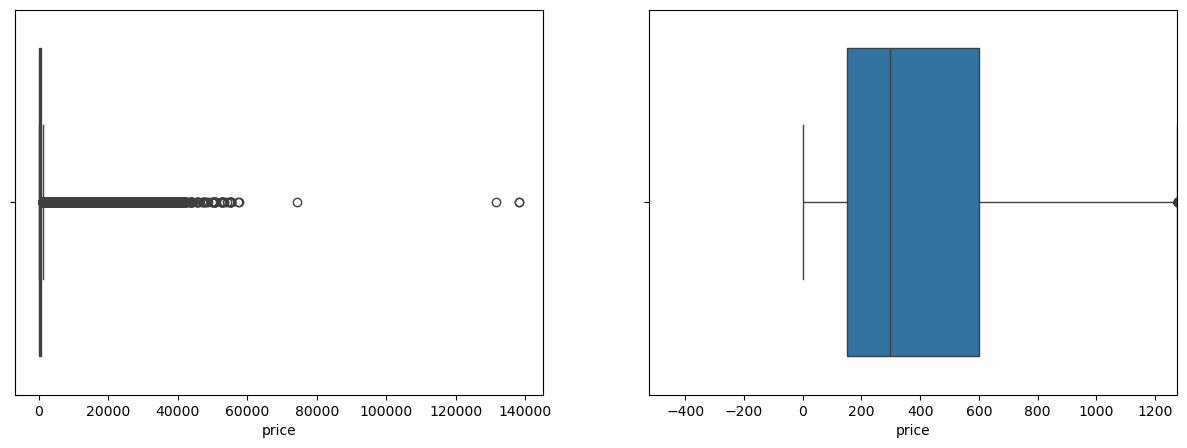

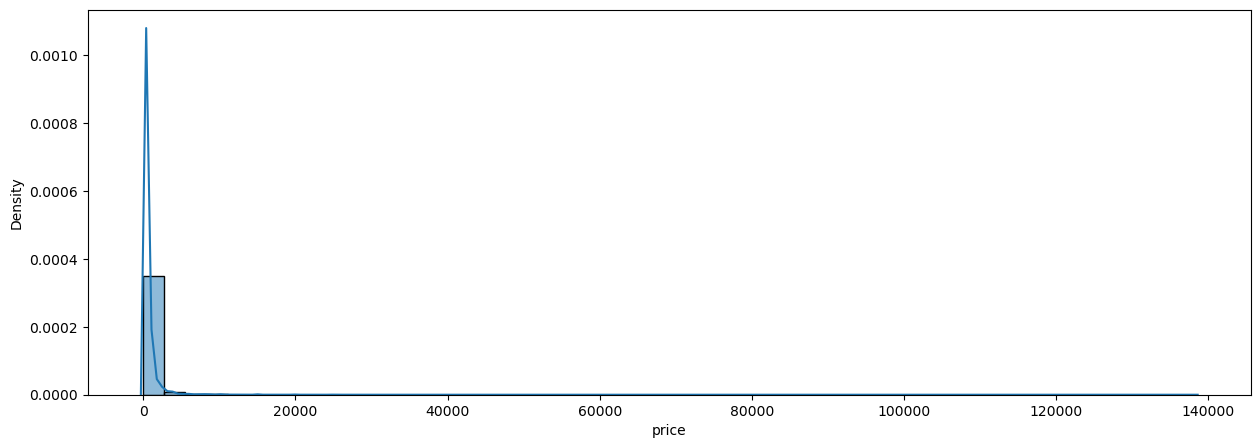

In [18]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

Como estamos constuindo um modelo para imóveis comuns, acredito que os valores acima do limite superior serão apenas de imóveis de altíssimo luxo, que não é nosso objetivo principal. Por isso, podemos excluir esses outliers

In [19]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print(f'{linhas_removidas} linhas removidas')

87282 linhas removidas


(810427, 23)


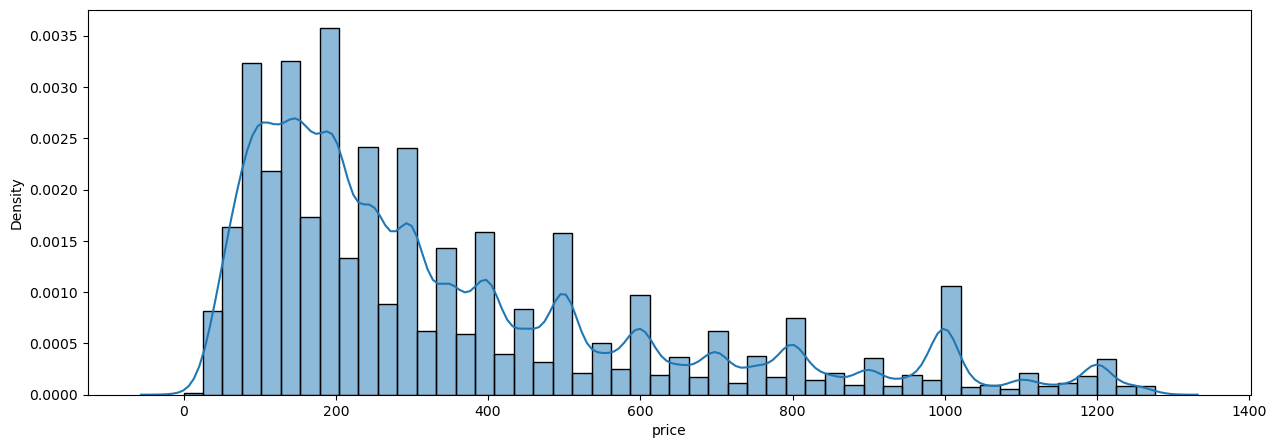

In [20]:
histograma(base_airbnb['price'])
print(base_airbnb.shape)

### extra_people

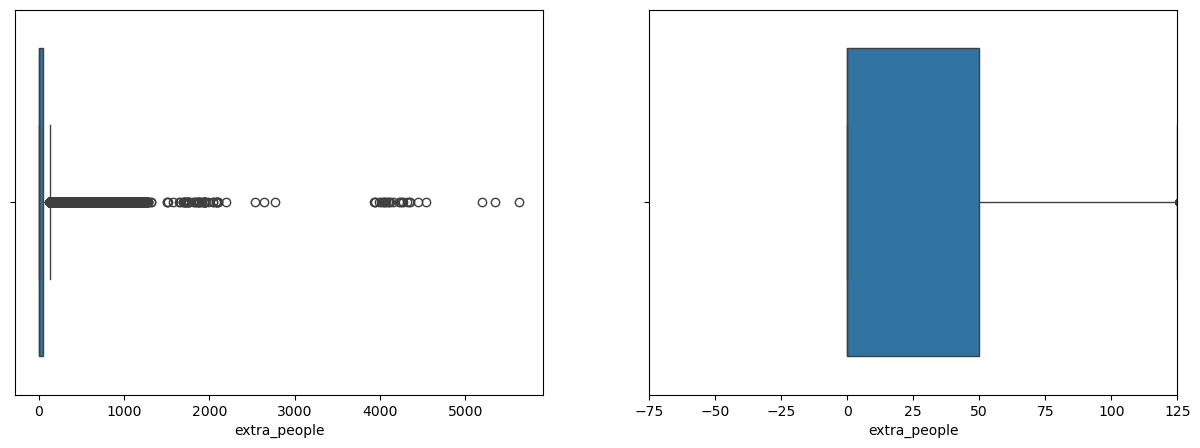

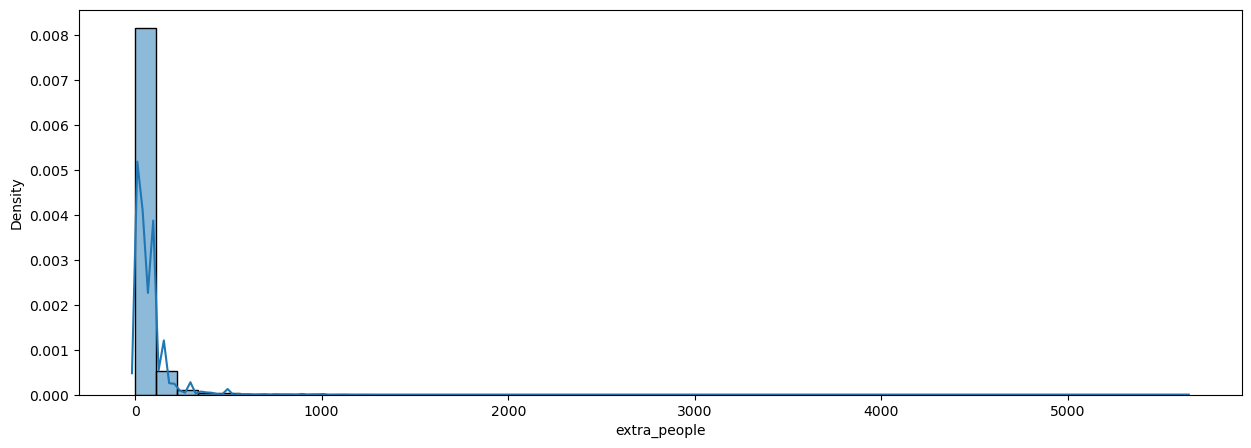

In [21]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [22]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print(f'{linhas_removidas} linhas removidas')
print(base_airbnb.shape)

59194 linhas removidas
(751233, 23)


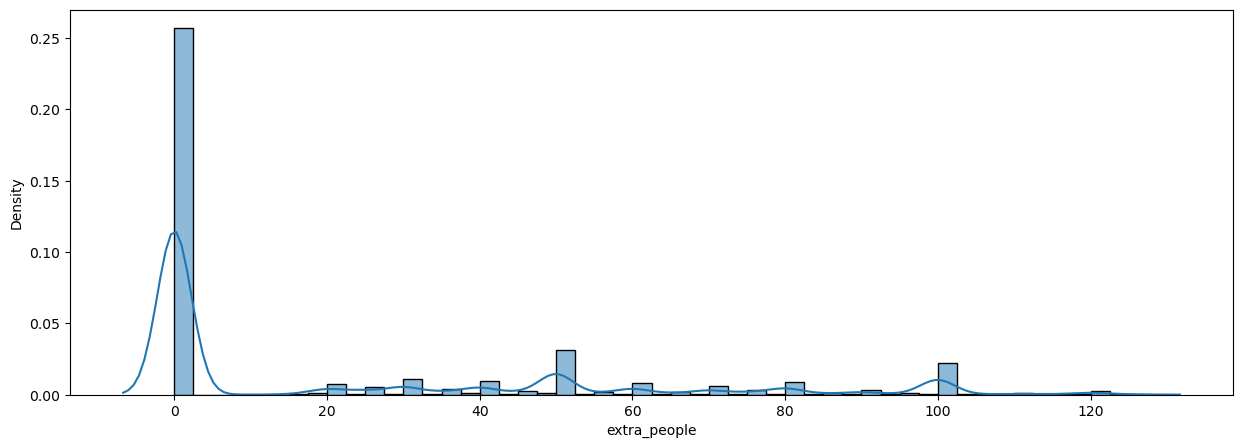

In [23]:
histograma(base_airbnb['extra_people'])

### host_listings_count  

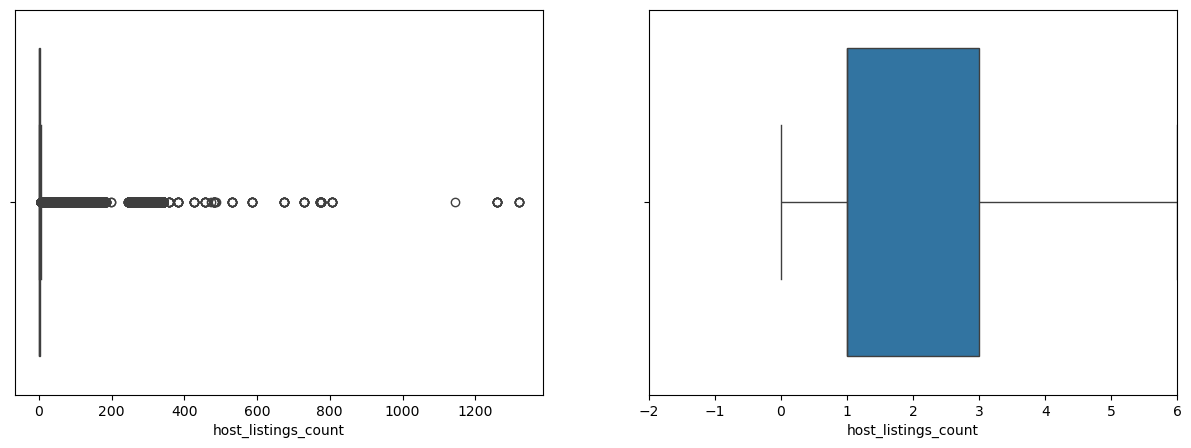

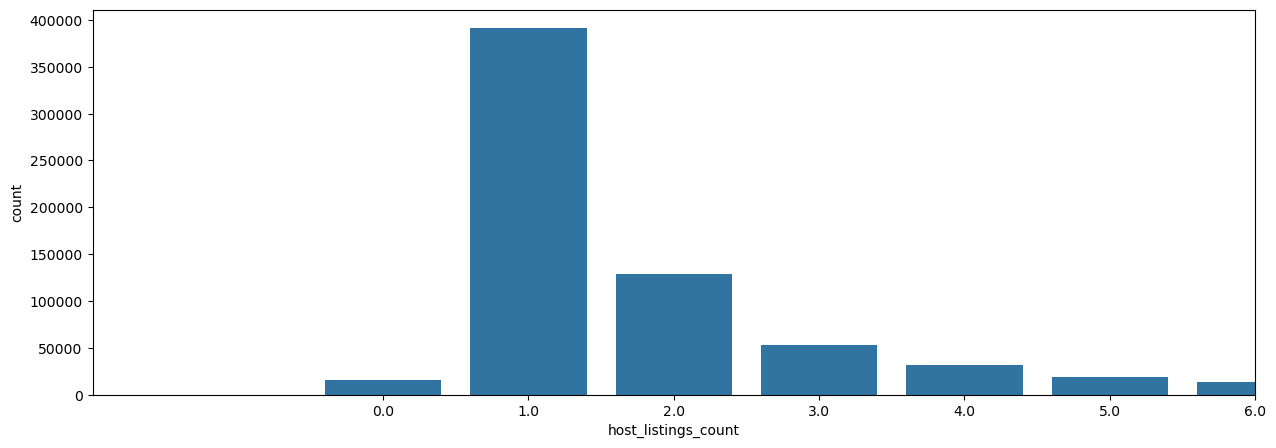

In [24]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

Podemos excluir os outliers, porque para o objetivo do nosso projeto porque hosts com mais de 6 imóveis no airbnb não é o público alvo do objetivo do projeto (imagino que sejam imobiliários que sejam imobiliários ou profissionais que gerenciam imóveis no airbnb)

In [25]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print(f'{linhas_removidas} linhas removidas')
print(base_airbnb.shape)

97723 linhas removidas
(653510, 23)


### accommodates 

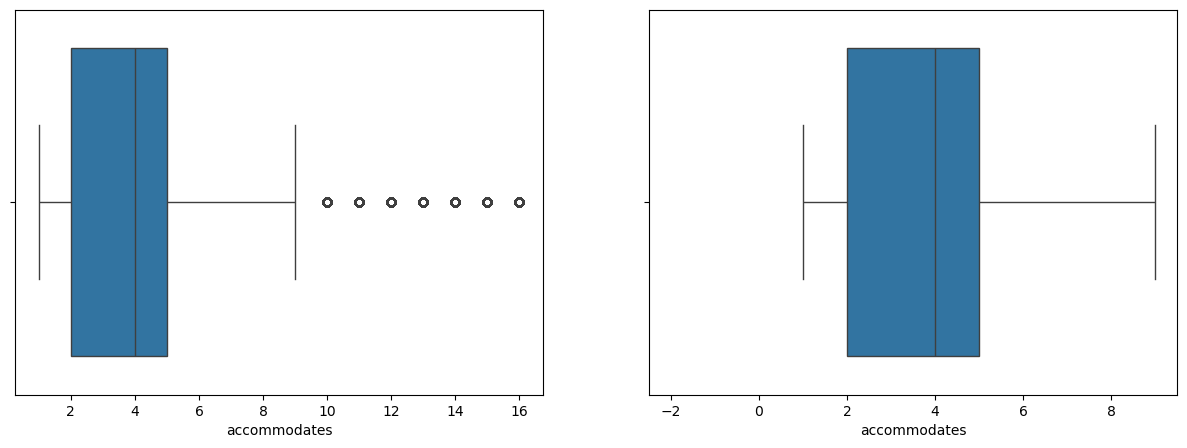

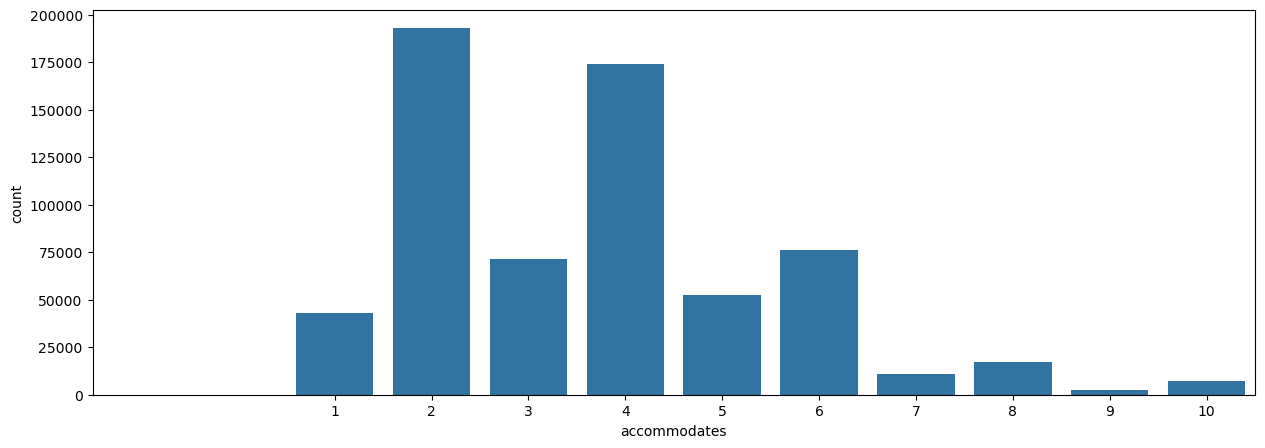

In [26]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [27]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print(f'{linhas_removidas} linhas removidas')
print(base_airbnb.shape)

13146 linhas removidas
(640364, 23)


### bathrooms 

<Axes: xlabel='bathrooms', ylabel='count'>

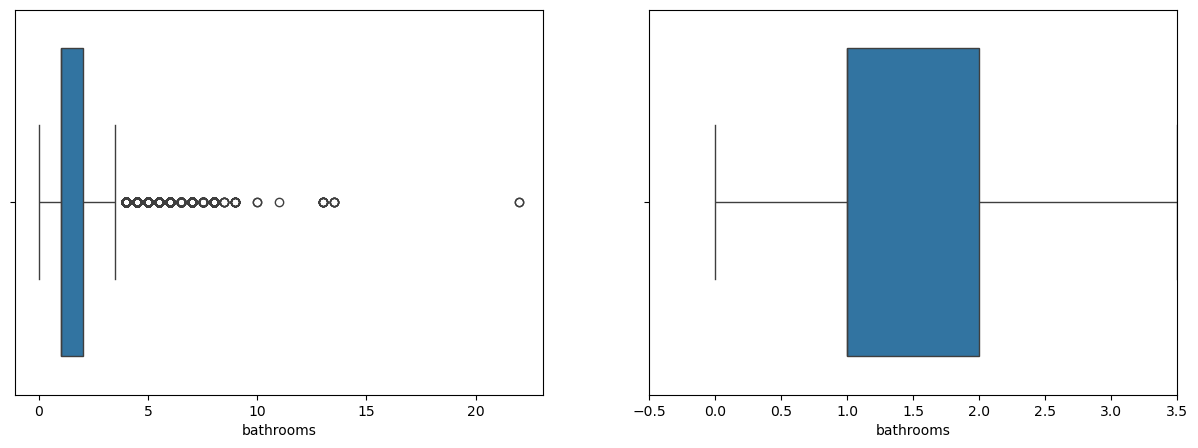

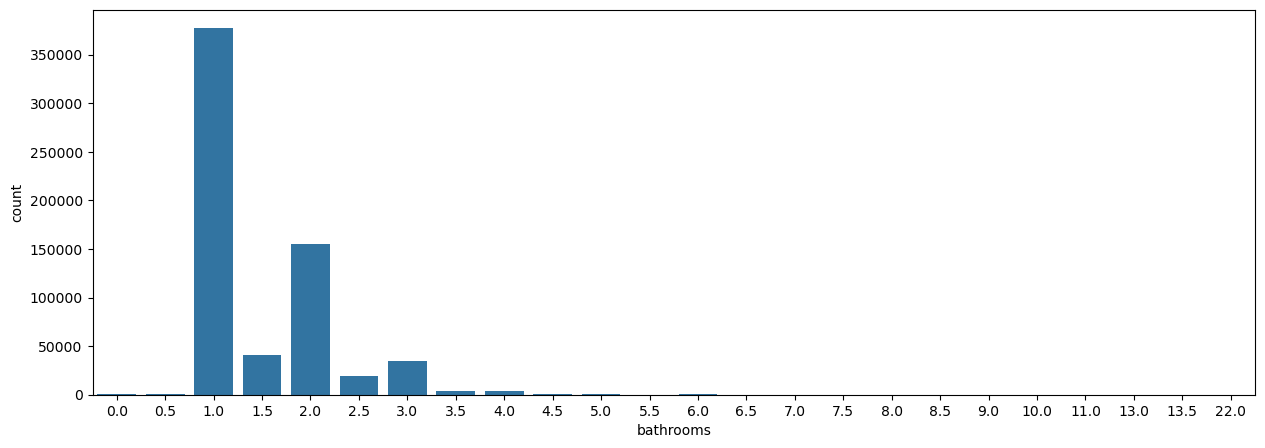

In [28]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

In [29]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print(f'{linhas_removidas} linhas removidas')
print(base_airbnb.shape)

6894 linhas removidas
(633470, 23)


### bedrooms 

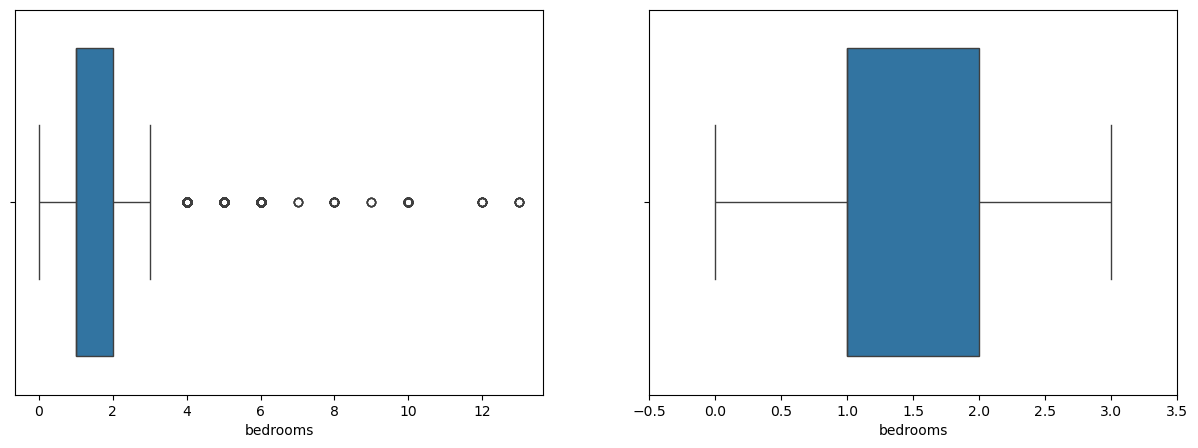

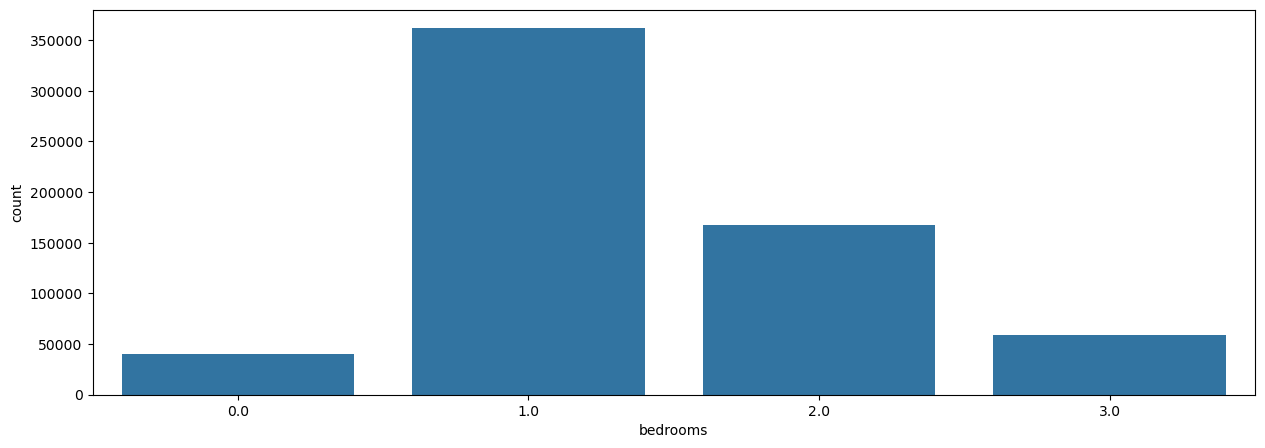

In [30]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [31]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print(f'{linhas_removidas} linhas removidas')
print(base_airbnb.shape)

5482 linhas removidas
(627988, 23)


### beds

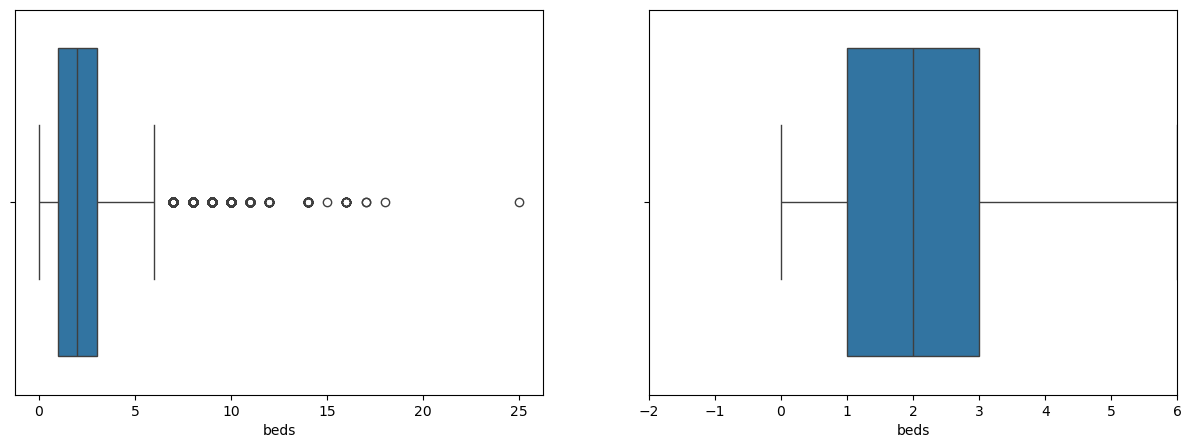

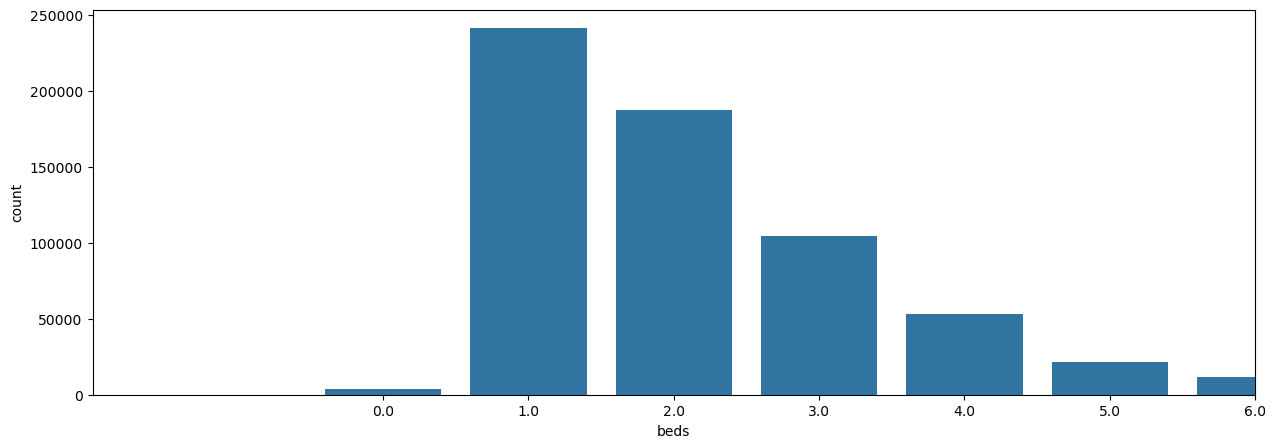

In [32]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [33]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print(f'{linhas_removidas} linhas removidas')
print(base_airbnb.shape)

5622 linhas removidas
(622366, 23)


### guests_included 

(1.0, 1.0)


<Axes: xlabel='guests_included', ylabel='count'>

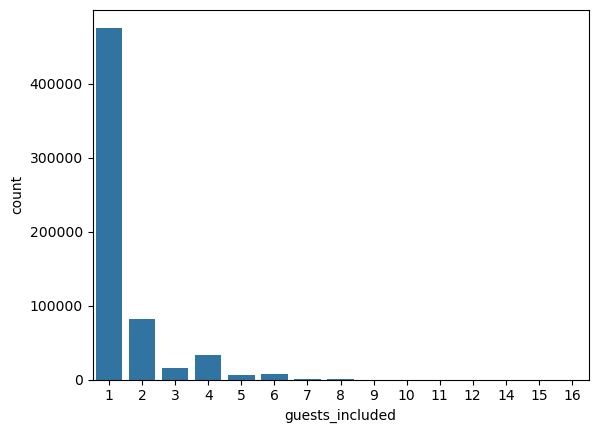

In [34]:
# diagrama_caixa(base_airbnb['guests_included'])
# grafico_barra(base_airbnb['guests_included'])

print(limites(base_airbnb['guests_included']))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

Vamos remover essa feature da análise. Parece que os usuários do airbnb usam muito o valor padrão do airbnb como 1 guest included. Isso pode levar o nosso modelo a considerar uma feature que na verdade não é essencial para a definição do preço. Por isso, me parece melhor excluir a coluna da análise.

In [35]:
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

### minimum_nights 

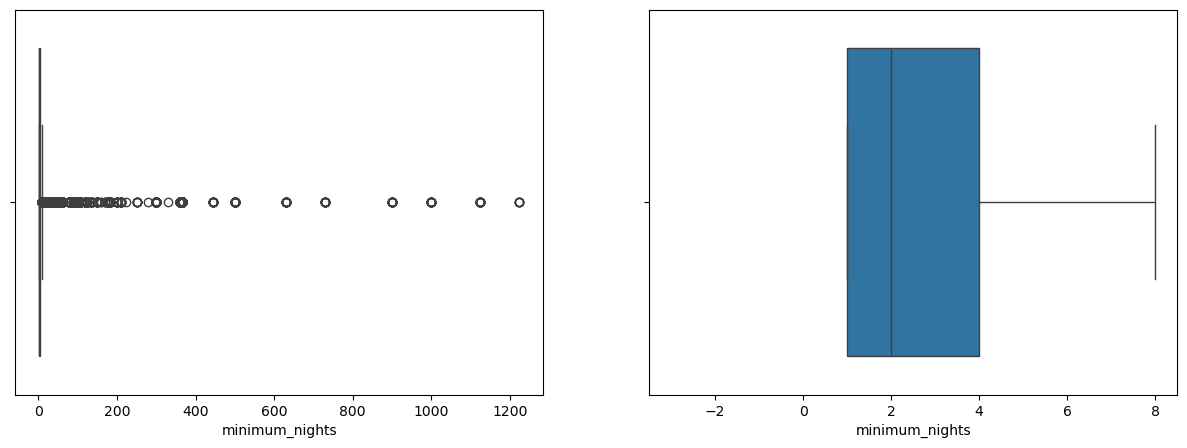

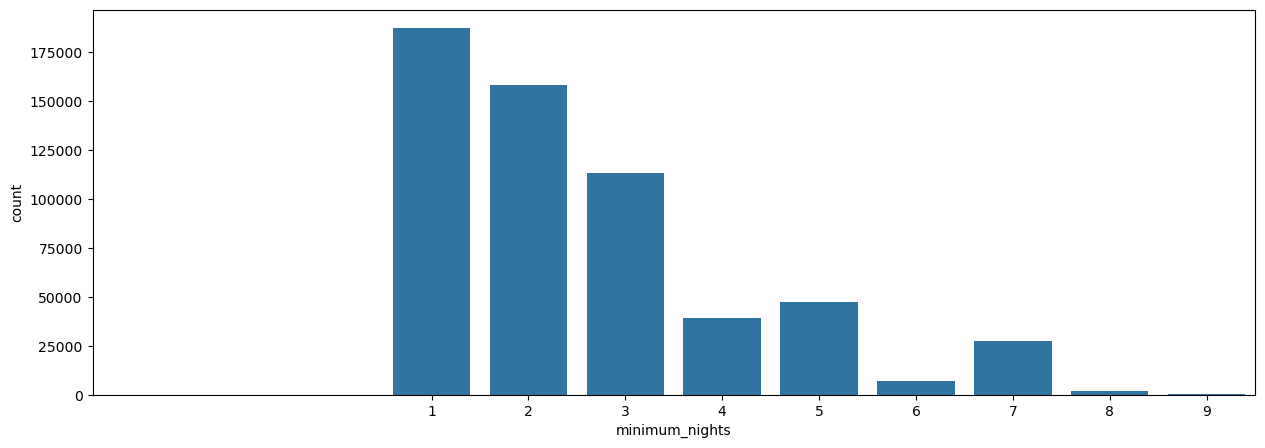

In [36]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [37]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print(f'{linhas_removidas} linhas removidas')
print(base_airbnb.shape)

40383 linhas removidas
(581983, 22)


### maximum_nights

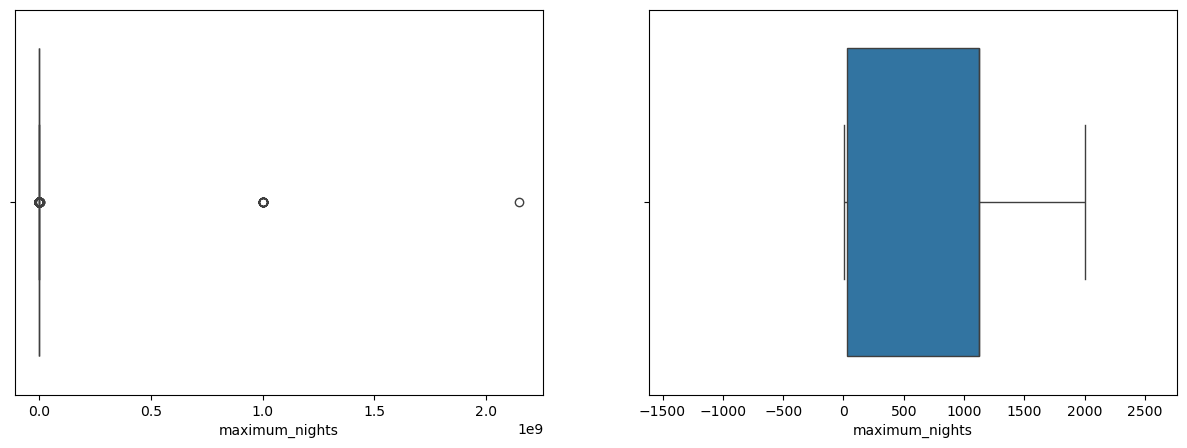

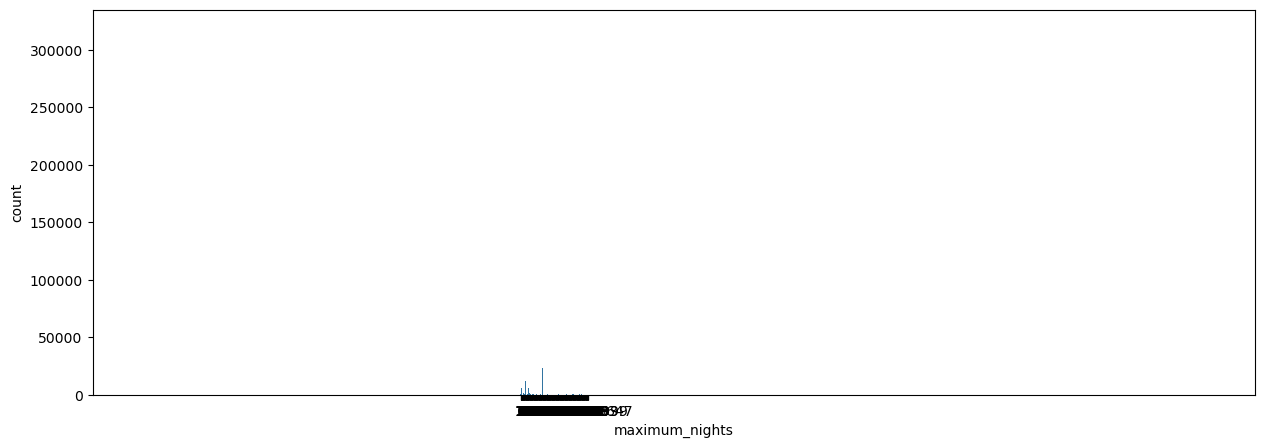

In [38]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

In [39]:
# Exclusão da coluna maximum_nights
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

### number_of_reviews

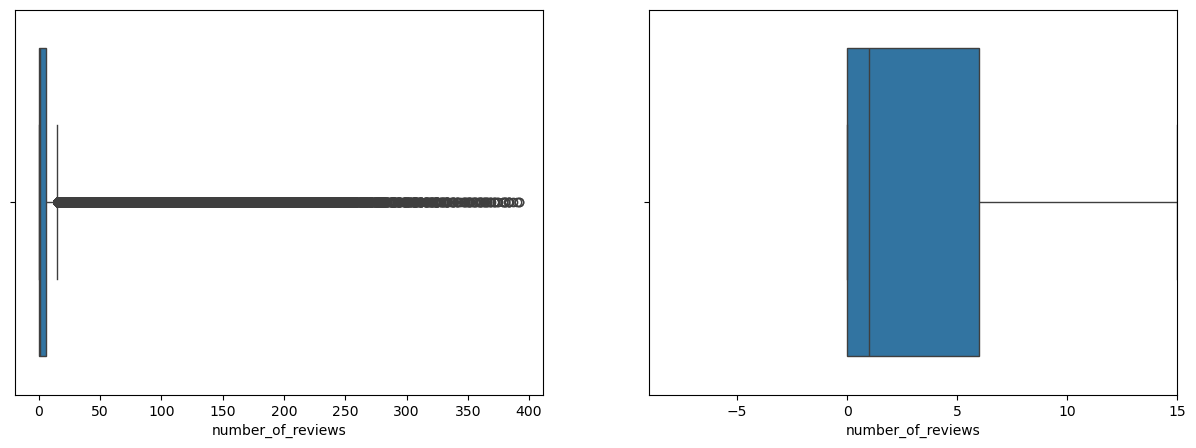

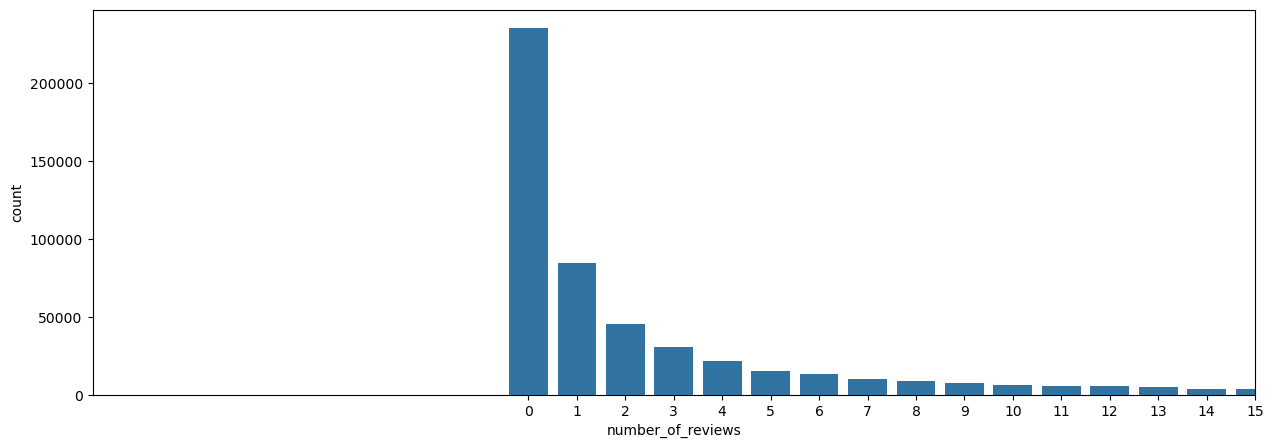

In [40]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

In [41]:
# Exclusão da coluna number_of_reviews
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

### Tratamento de Colunas de Valores de Texto

- property_type

property_type
Apartment                 458354
House                      51387
Condominium                26456
Serviced apartment         12671
Loft                       12352
Guest suite                 3621
Bed and breakfast           3472
Hostel                      2665
Guesthouse                  2155
Other                       1957
Villa                       1294
Townhouse                    969
Aparthotel                   693
Chalet                       481
Earth house                  468
Tiny house                   457
Boutique hotel               447
Hotel                        376
Casa particular (Cuba)       298
Cottage                      230
Bungalow                     207
Dorm                         185
Cabin                        141
Nature lodge                 124
Castle                        80
Treehouse                     76
Island                        54
Boat                          53
Hut                           40
Campsite                     

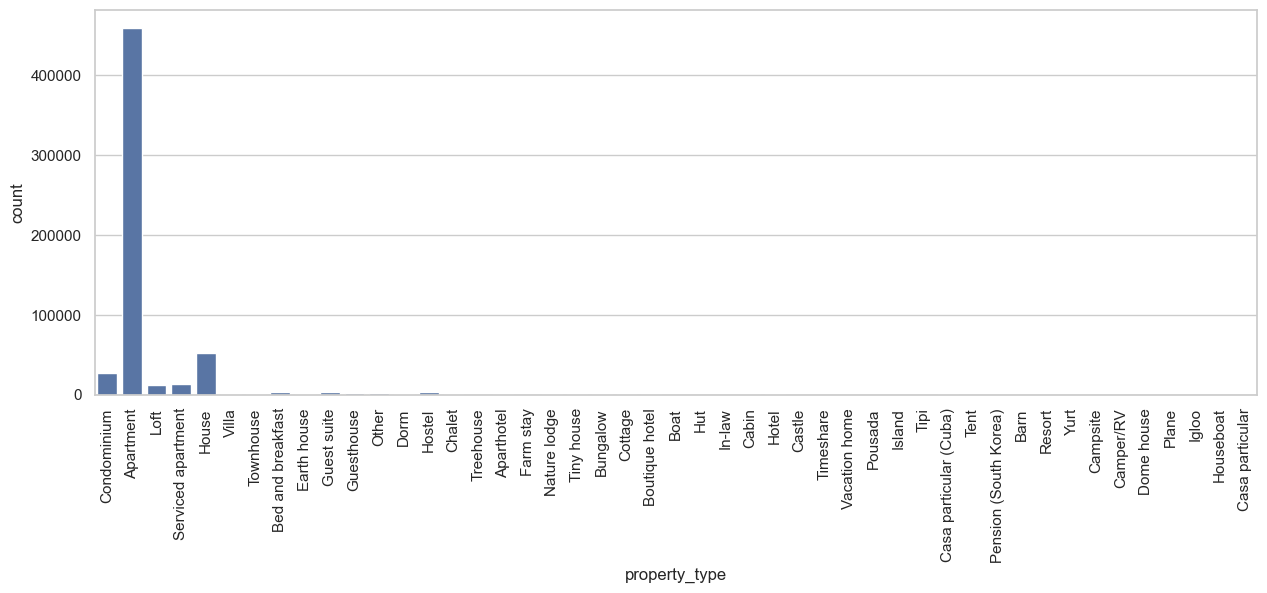

In [42]:
print(base_airbnb['property_type'].value_counts())
plt.figure(figsize=(15, 5))
sns.set_theme(style='whitegrid')
grafico = sns.countplot(x=base_airbnb['property_type'])
grafico.tick_params(axis='x', rotation=90)

['Other', 'Villa', 'Townhouse', 'Aparthotel', 'Chalet', 'Earth house', 'Tiny house', 'Boutique hotel', 'Hotel', 'Casa particular (Cuba)', 'Cottage', 'Bungalow', 'Dorm', 'Cabin', 'Nature lodge', 'Castle', 'Treehouse', 'Island', 'Boat', 'Hut', 'Campsite', 'Resort', 'Camper/RV', 'Yurt', 'Tent', 'Tipi', 'Barn', 'Farm stay', 'Pension (South Korea)', 'Dome house', 'Igloo', 'In-law', 'Vacation home', 'Timeshare', 'Pousada', 'Houseboat', 'Casa particular', 'Plane']
property_type
Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: count, dtype: int64


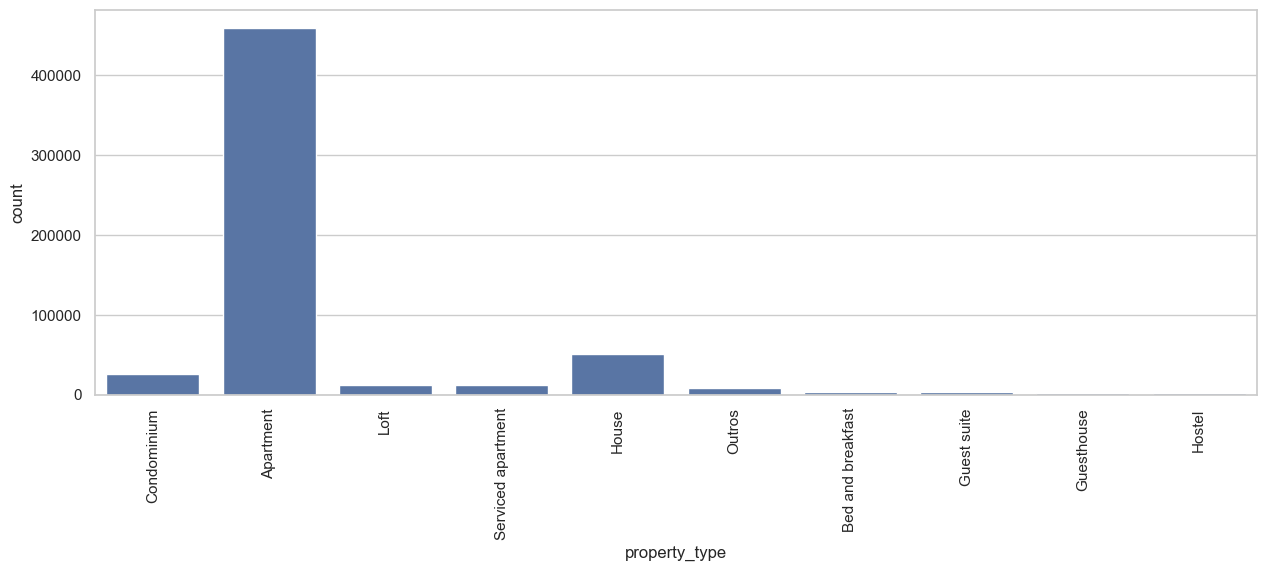

In [43]:
tabela_tipos_casa = base_airbnb['property_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_tipos_casa.index:
    if tabela_tipos_casa[tipo] < 2000:
        colunas_agrupar.append(tipo)

print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['property_type'] == tipo, 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())
plt.figure(figsize=(15, 5))
sns.set_theme(style='whitegrid')
grafico = sns.countplot(x=base_airbnb['property_type'])
grafico.tick_params(axis='x', rotation=90)

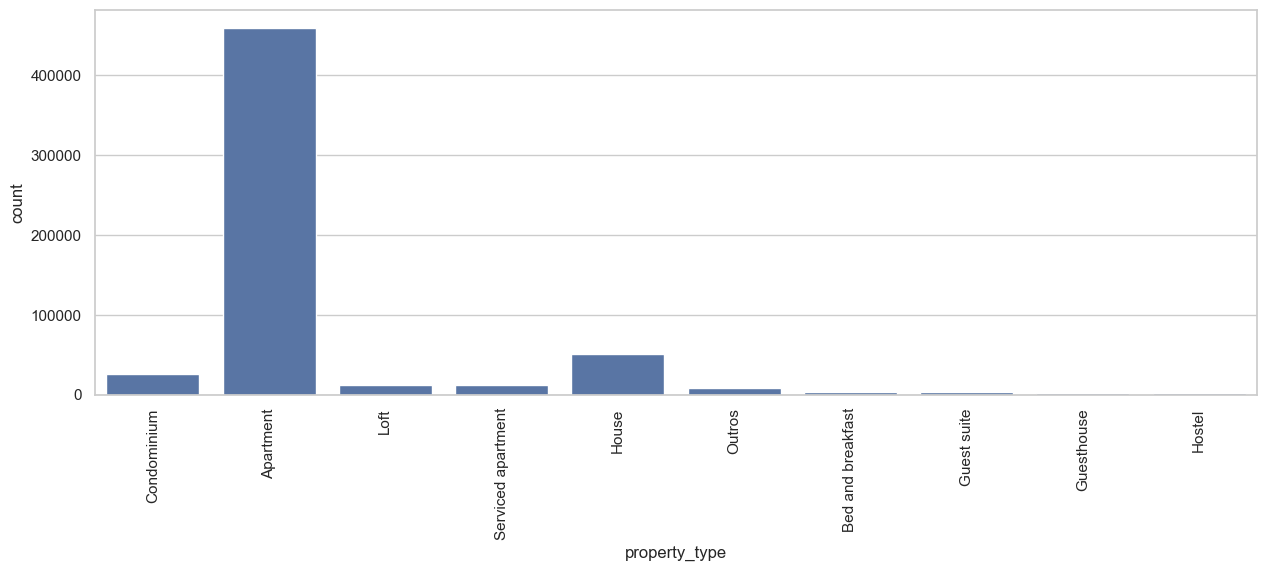

In [44]:
plt.figure(figsize=(15, 5))
grafico = sns.countplot(x=base_airbnb['property_type'])
grafico.tick_params(axis='x', rotation=90)

- room_type

room_type
Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: count, dtype: int64


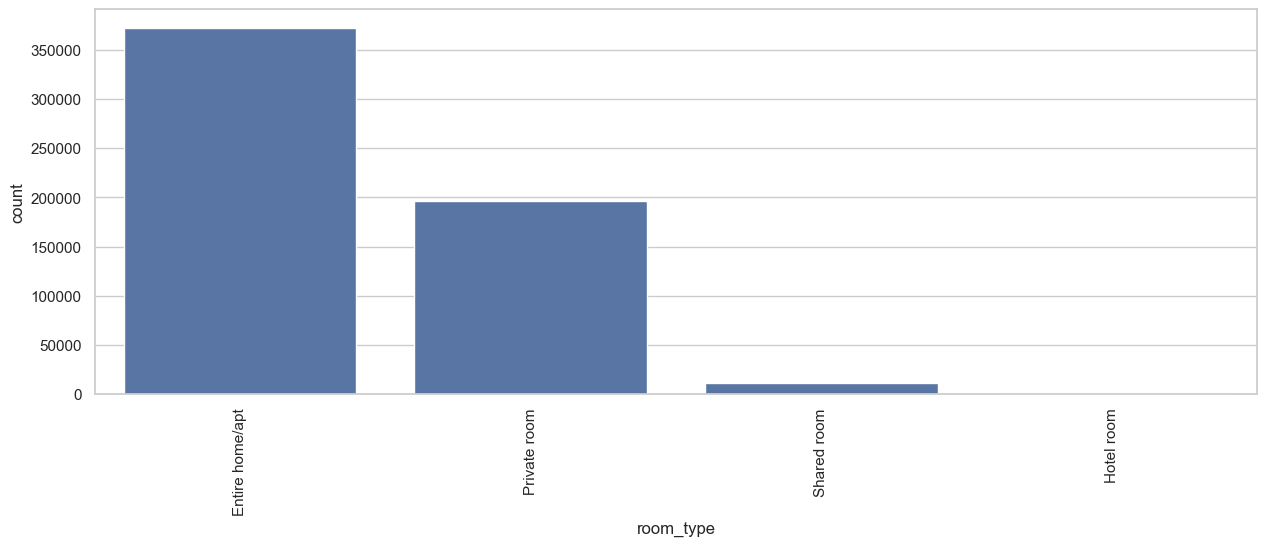

In [45]:
print(base_airbnb['room_type'].value_counts())

plt.figure(figsize=(15, 5))
sns.set_theme(style='whitegrid')
grafico = sns.countplot(x=base_airbnb['room_type'])
grafico.tick_params(axis='x', rotation=90)

- bed_type

bed_type
Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: count, dtype: int64
['Pull-out Sofa', 'Futon', 'Airbed', 'Couch']
bed_type
Real Bed                570643
Outros Tipos de Cama     11340
Name: count, dtype: int64


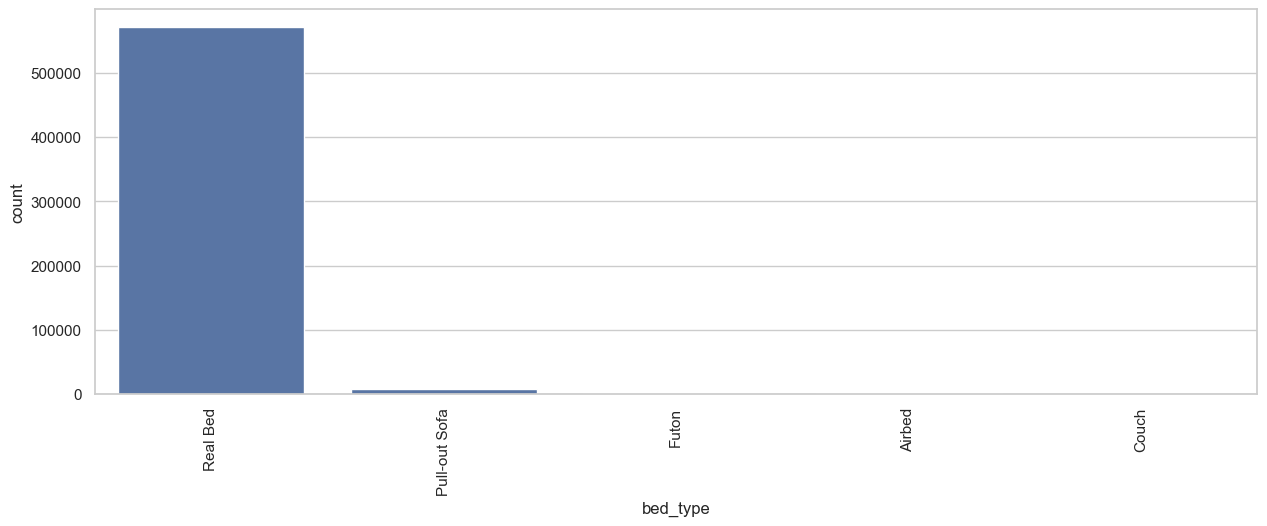

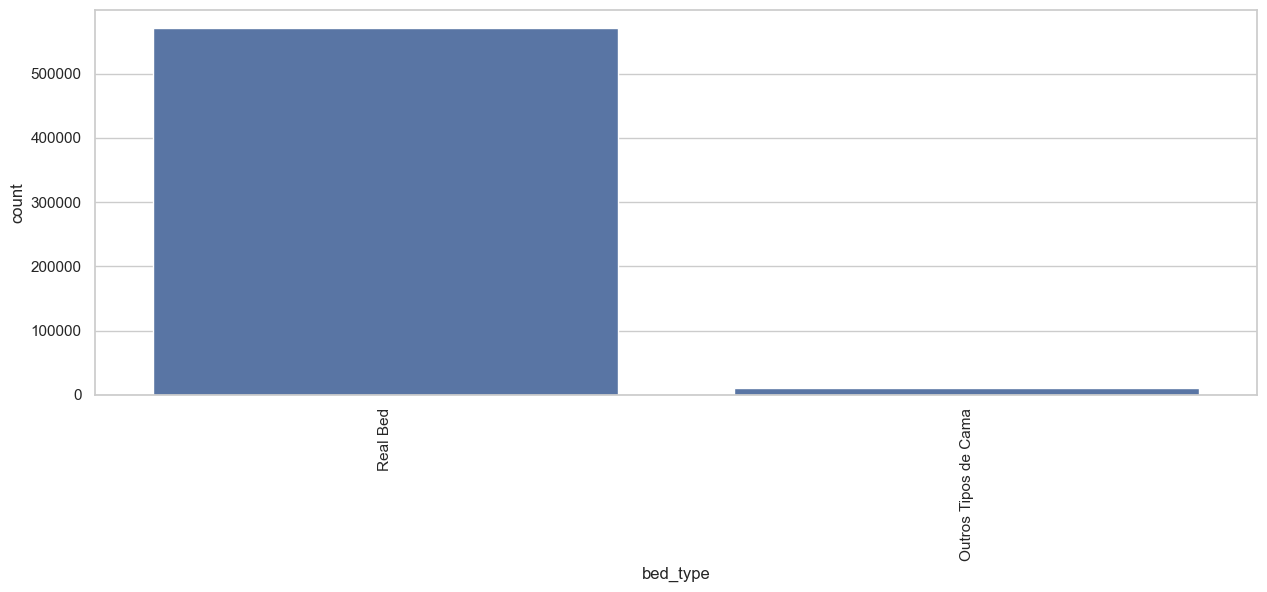

In [46]:
print(base_airbnb['bed_type'].value_counts())

plt.figure(figsize=(15, 5))
sns.set_theme(style='whitegrid')
grafico = sns.countplot(x=base_airbnb['bed_type'])
grafico.tick_params(axis='x', rotation=90)

# Recomendação para agrupar em duas colunas: Real Bed e Outras camas(Agrupando os valores de outras camas com menores valores)

# Agrupando categorias de bed_type
tabela_bed_type = base_airbnb['bed_type'].value_counts()
colunas_agrupar = []

for tipo in tabela_bed_type.index:
    if tabela_bed_type[tipo] < 10000:
        colunas_agrupar.append(tipo)

print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['bed_type'] == tipo, 'bed_type'] = 'Outros Tipos de Cama'

print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15, 5))
sns.set_theme(style='whitegrid')
grafico = sns.countplot(x=base_airbnb['bed_type'])
grafico.tick_params(axis='x', rotation=90)

- cancellation_policy

cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: count, dtype: int64
['strict', 'super_strict_60', 'super_strict_30']
cancellation_policy
flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: count, dtype: int64


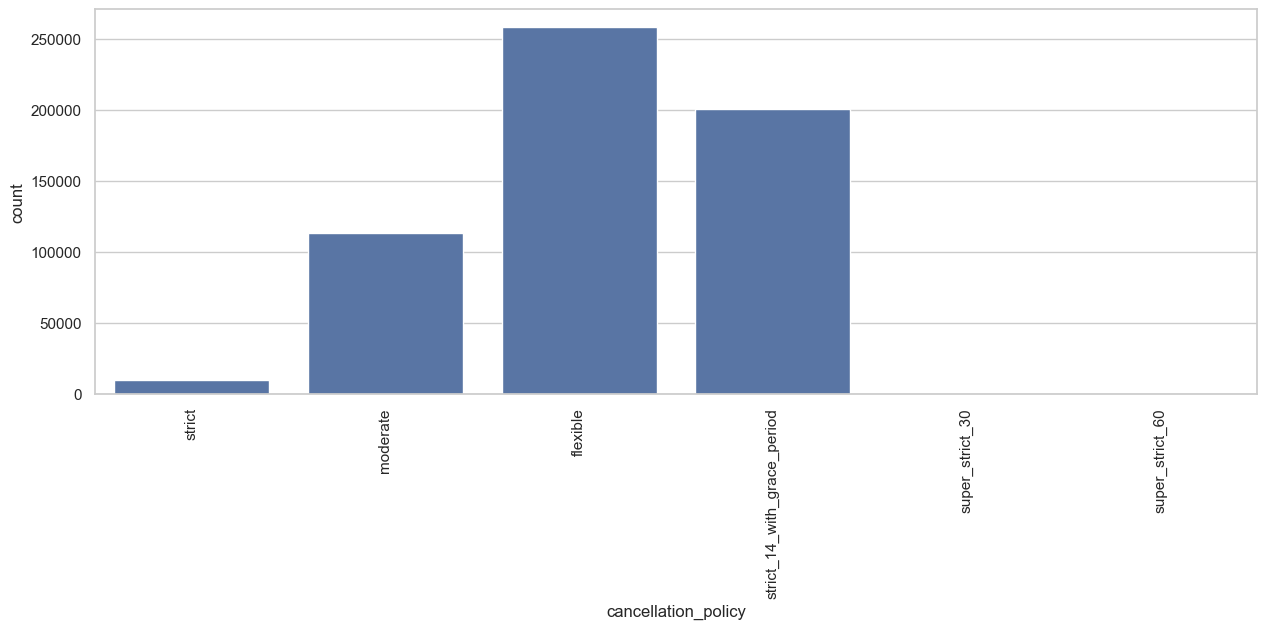

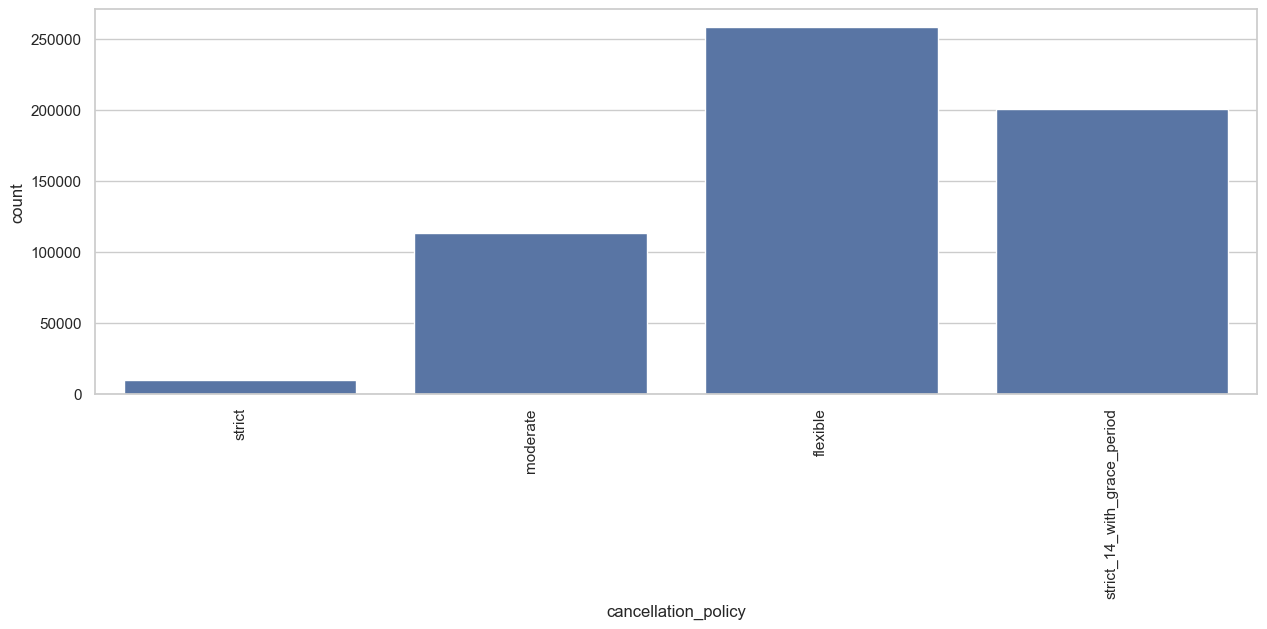

In [47]:
print(base_airbnb['cancellation_policy'].value_counts())

plt.figure(figsize=(15, 5))
sns.set_theme(style='whitegrid')
grafico = sns.countplot(x=base_airbnb['cancellation_policy'])
grafico.tick_params(axis='x', rotation=90)

# Agrupando categorias de cancellation_policy
tabela_cancellation_policy = base_airbnb['cancellation_policy'].value_counts()
colunas_agrupar = []

for tipo in tabela_cancellation_policy.index:
    if tabela_cancellation_policy[tipo] < 10000:
        colunas_agrupar.append(tipo)

print(colunas_agrupar)

for tipo in colunas_agrupar:
    base_airbnb.loc[base_airbnb['cancellation_policy'] == tipo, 'cancellation_policy'] = 'strict'

print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15, 5))
sns.set_theme(style='whitegrid')
grafico = sns.countplot(x=base_airbnb['cancellation_policy'])
grafico.tick_params(axis='x', rotation=90)


- amenities

Como temos uma diversidade muito grande de amenities e, às vezes, as mesmas amenities podem ser escritas de forma diferente, vamos avaliar a quantidade de amenities como o parâmetro para o modelo

In [48]:
print(base_airbnb['amenities'].iloc[1].split(','))
print(len(base_airbnb['amenities'].iloc[1].split(',')))

base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)
base_airbnb.shape

['{TV', '"Cable TV"', 'Internet', 'Wifi', '"Air conditioning"', 'Kitchen', 'Doorman', 'Elevator', '"Buzzer/wireless intercom"', '"Family/kid friendly"', 'Hangers', '"Hair dryer"', 'Iron', '"Laptop friendly workspace"}']
14


(581983, 21)

In [49]:
# Exclusão da coluna amenities
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(581983, 20)

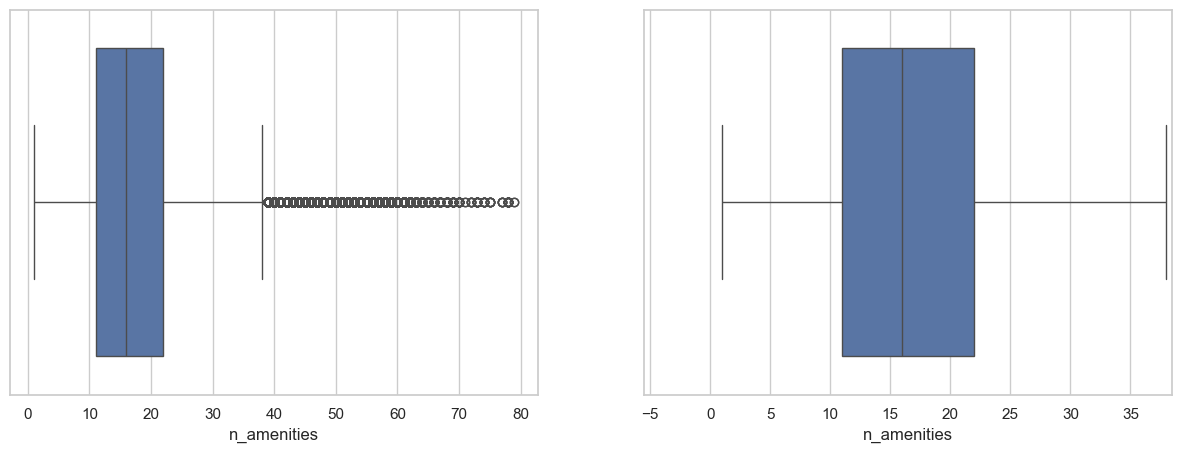

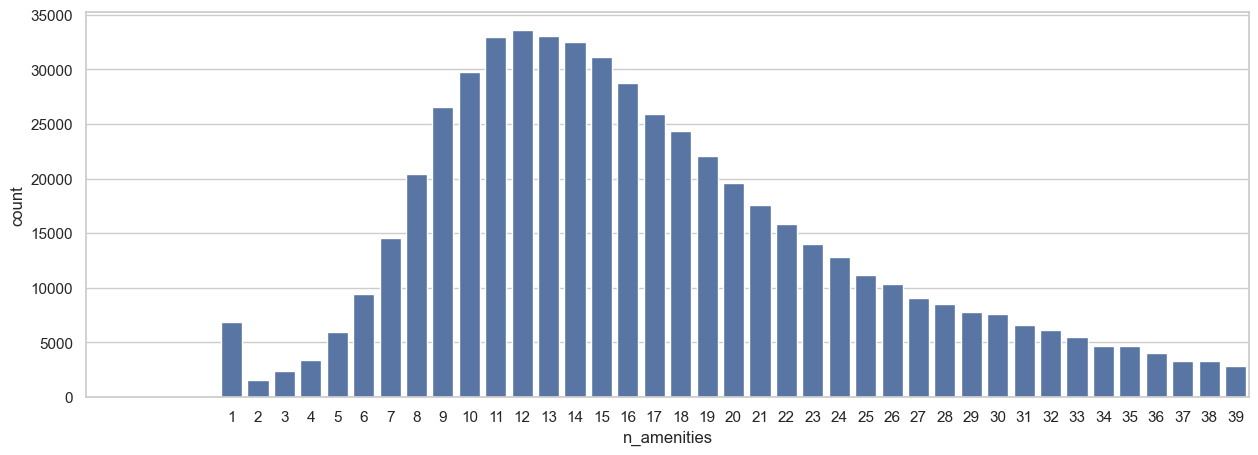

In [50]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [51]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print(f'{linhas_removidas} linhas removidas')
print(base_airbnb.shape)

24343 linhas removidas
(557640, 20)


### Visualização de Mapa das Propriedades

In [52]:
amostra = base_airbnb.sample(n=50000)
centro_mapa = {'lat':amostra.latitude.mean(), 'lon':amostra.longitude.mean()}
mapa = px.density_map(amostra, lat='latitude', lon='longitude',z='price', radius=2.5,
                        center=centro_mapa, zoom=10,
                        map_style='open-street-map')
mapa.show()

### Encoding

Precisamor Ajustar as features para facilitar o trabalho do modelo futuro (features de categoria, true e false, etc.)

- Features de Valores True ou False, vamos substituir True por 1 e False por 0.
- Features de Categoria (features em que os valores da coluna são textos) vamos utilizar o método de encoding de variáveis dummies

OBS.:
O que são variáveis dummy:

- Variáveis binárias: Representam categorias usando apenas dois valores: 0 e 1.
- Representação de categorias: Permitem incluir variáveis categóricas em análises quantitativas, como modelos de regressão.
- Ausência ou presença: O valor 1 indica a presença da categoria, enquanto o valor 0 indica a ausência. 

One-Hot Encoding: é um método de conversão de variáveis categóricas em um formato que pode ser fornecido a algoritmos de machine learning para melhorar a previsão. Isso envolve a criação de novas colunas binárias para cada categoria exclusiva em um recurso. Cada coluna representa uma categoria exclusiva, e um valor de 1 ou 0 indica a presença ou ausência dessa categoria.

In [53]:
colunas_tf = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']
base_airbnb_enconding = base_airbnb.copy()
for coluna in colunas_tf:
    base_airbnb_enconding.loc[base_airbnb_enconding[coluna] == 't', coluna] = 1
    base_airbnb_enconding.loc[base_airbnb_enconding[coluna] == 'f', coluna] = 0

In [54]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']

base_airbnb_enconding = pd.get_dummies(data=base_airbnb_enconding, columns=colunas_categorias, dtype=int)
display(base_airbnb_enconding.head())

host_listings_count host_is_superhost   latitude  longitude  accommodates  \
1                  2.0                 1 -22.965919 -43.178962             5   
3                  3.0                 0 -22.977117 -43.190454             3   
4                  1.0                 1 -22.983024 -43.214270             3   
5                  1.0                 1 -22.988165 -43.193588             3   
6                  1.0                 1 -22.981269 -43.190457             2   

   bathrooms  bedrooms  beds  price  extra_people  ...  \
1        1.0       2.0   2.0  270.0          51.0  ...   
3        1.0       1.0   2.0  161.0          45.0  ...   
4        1.0       1.0   2.0  222.0          68.0  ...   
5        1.5       1.0   2.0  308.0          86.0  ...   
6        1.0       1.0   2.0  219.0          80.0  ...   

   room_type_Entire home/apt room_type_Hotel room room_type_Private room  \
1                          1                    0                      0   
3                          1                    0                      0   
4                          1                    0                      0   
5                          1                    0                      0   
6                          1                    0                      0   

   room_type_Shared room  bed_type_Outros Tipos de Cama  bed_type_Real Bed  \
1                      0                              0                  1   
3                      0                              0                  1   
4                      0                              0                  1   
5                      0                              0                  1   
6                      0                              0                  1   

   cancellation_policy_flexible  cancellation_policy_moderate  \
1                             0                             0   
3                             0                             0   
4                             0                             0   
5                             0                             0   
6                             0                             0   

   cancellation_policy_strict  cancellation_policy_strict_14_with_grace_period  
1                           1                                                0  
3                           1                                                0  
4                           1                                                0  
5                           1                                                0  
6                           1                                                0  

[5 rows x 36 columns]

### Modelo de Previsão

- Métricas de Avaliação

In [55]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))
    return f'Modelo {nome_modelo}:\nR²:{r2:.2%}\nRSME: {RSME:.2f}'

- Escolha dos modelos a serem Testados
    1. RandomForest
    2. LinearRegression
    3. Extra Tree

In [56]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {
    'RandomForest': modelo_rf,
    'LinearRegression': modelo_lr,
    'ExtraTrees': modelo_et,
}

# Separação das variáveis
X = base_airbnb_enconding.drop('price', axis=1)
y = base_airbnb_enconding['price']

- Separação dos dados em treino e teste + Treino do Modelo

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

for nome_modelo, modelo in modelos.items():
    # Treinar
    modelo.fit(X_train, y_train)

    # Testar
    previsao = modelo.predict(X_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))

Modelo RandomForest:
R²:97.24%
RSME: 44.09
Modelo LinearRegression:
R²:32.70%
RSME: 217.54
Modelo ExtraTrees:
R²:97.50%
RSME: 41.91


### Análise do Melhor Modelo

Minha análise é que tanto o modelo RandomForest quanto o Modelo ExtraTrees possuem bons resultados para serem usados como um bom modelo. Porém, analisando com ímpeto, o R² possuem resultados parecidos dos dois, mas com o RSME, o modelo ExtraTrees possui menos erros do que o RandomForest. Então, o modelo ExtraTrees é o melhor modelo para esse caso.

Em suma:
- Modelo Escolhido como Melhor Modelo: ExtraTreesRegressor

Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não tivemos uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de RandomForest (que teve resultados próximos de R² e RSME), vamos escolher o Modelo ExtraTrees.

O modelo de regressão Linear não obteve resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2 modelos.

- Resultados das Métricas de avaliação no Modelo Vencedor:

Modelo ExtraTrees:

R²:97.50%

RSME: 41.93


### Ajustes e Melhorias no Melhor Modelo

0
bedrooms                                         0.115265
latitude                                         0.103680
longitude                                        0.101389
n_amenities                                      0.089114
extra_people                                     0.086495
accommodates                                     0.071843
bathrooms                                        0.068575
room_type_Entire home/apt                        0.066021
minimum_nights                                   0.064788
beds                                             0.053239
host_listings_count                              0.040210
instant_bookable                                 0.021930
cancellation_policy_flexible                     0.019497
host_is_superhost                                0.013680
property_type_Apartment                          0.012830
cancellation_policy_moderate                     0.012284
ano                                              0.011351
cancellation_policy_strict_14_with_grace_period  0.007735
property_type_House                              0.007125
property_type_Condominium                        0.005186
mes                                              0.004737
room_type_Private room                           0.004200
bed_type_Real Bed                                0.002775
bed_type_Outros Tipos de Cama                    0.002651
property_type_Outros                             0.002393
property_type_Serviced apartment                 0.002248
property_type_Loft                               0.002185
room_type_Shared room                            0.001881
property_type_Bed and breakfast                  0.001298
property_type_Guesthouse                         0.000935
cancellation_policy_strict                       0.000836
property_type_Guest suite                        0.000673
property_type_Hostel                             0.000630
room_type_Hotel room                             0.000322
is_business_travel_ready                         0.000000

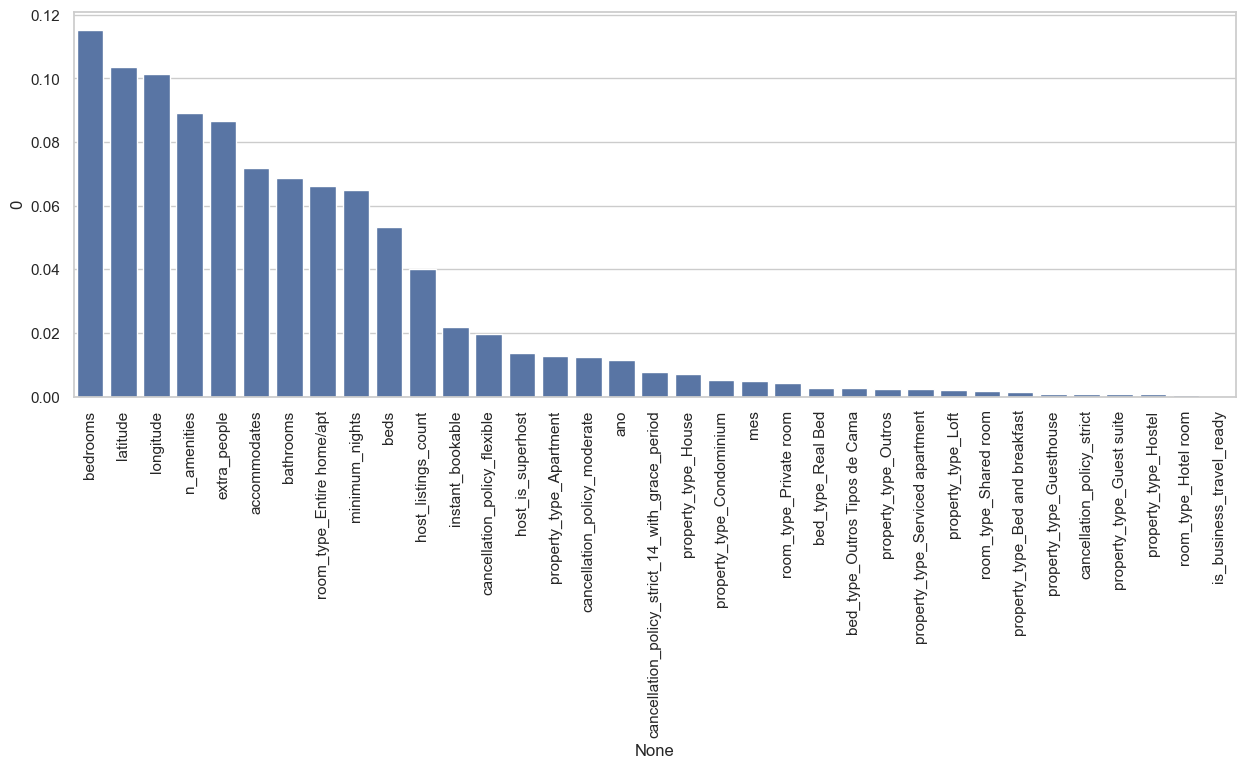

In [58]:
# Lista de features com a numeração de nível de importância
# print(modelo_et.feature_importances_)

# As colunas que está usando para as features serem treinadas
# print(X_train.columns)

importancia_features = pd.DataFrame(modelo_et.feature_importances_, X_train.columns)

# Ordenar os valores
importancia_features = importancia_features.sort_values(by=0, ascending=False)

display(importancia_features)

plt.figure(figsize=(15, 5))
ax = sns.barplot(x=importancia_features.index, y=importancia_features[0])
ax = ax.tick_params(axis='x', rotation=90)
# ax.set_xlim(limites(coluna))

### Ajustes Finais no Modelo

- is_business_travel_ready não parece ter muito impacto no nosso modelo. Por isso, para chegar em um modelo mais simples, vamos excluir essa feature e testar o modelo sem ela

In [59]:
base_airbnb_enconding = base_airbnb_enconding.drop('is_business_travel_ready', axis=1)

X = base_airbnb_enconding.drop('price', axis=1)
y = base_airbnb_enconding['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)


# Treinar
modelo_et.fit(X_train, y_train)

# Testar
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees:
R²:97.49%
RSME: 41.98


In [60]:
base_teste = base_airbnb_enconding.copy()
for coluna in base_teste:
    if 'bed_type' in coluna:
        base_teste = base_teste.drop(coluna, axis=1)

X = base_teste.drop('price', axis=1)
y = base_teste['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)


# Treinar
modelo_et.fit(X_train, y_train)

# Testar
previsao = modelo_et.predict(X_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo ExtraTrees:
R²:97.49%
RSME: 42.05


In [61]:
print(previsao)

[101.   998.59 249.2  ... 123.8  287.17 119.94]


Resultados dos 3 testes:

- Modelo ExtraTrees:
    1. Teste:
        - R²:97.50%
        - RSME: 41.93
    2. Teste:
        - R²:97.49%
        - RSME: 42.05
    2. Teste:
        - R²:97.50%
        - RSME: 41.97

O modelo ficou mais simples, e continua sendo uma boa opção

# Deploy do Projeto

- Passo 1 -> Criar arquivo do Modelo (joblib)<br>
- Passo 2 -> Escolher a forma de deploy:
    - Arquivo Executável + Tkinter
    - Deploy em Microsite (Flask)
    - Deploy apenas para uso direto Streamlit
- Passo 3 -> Outro arquivo Python (pode ser Jupyter ou PyCharm)
- Passo 4 -> Importar streamlit e criar código
- Passo 5 -> Atribuir ao botão o carregamento do modelo
- Passo 6 -> Deploy feito

In [62]:
X['price'] = y
X.to_csv('dados.csv')

In [63]:
import joblib
joblib.dump(modelo_et, 'modelo.joblib')

['modelo.joblib']